# Image Colorization Model using Generative Adversarial Network

## Definition of GAN
[Generative Adversarial Networks](https://arxiv.org/abs/1406.2661) (GANs) are one of the most interesting ideas in computer science today. Two models are trained simultaneously by an adversarial process. A *generator* ("the artist") learns to create images that look real, while a *discriminator* ("the art critic") learns to tell real images apart from fakes.


During training, the *generator* progressively becomes better at creating images that look real, while the *discriminator* becomes better at telling them apart. The process reaches equilibrium when the *discriminator* can no longer distinguish real images from fakes.


In this notebook, we will use GAN process to colorize the images on the CIFAR-10 dataset. 

### Import TensorFlow and other libraries

In [1]:
import tensorflow as tf
tf.__version__

'2.2.0'

In [0]:
# To generate GIFs
!pip install -q imageio

In [3]:
import os
import PIL
import time
import pickle
from sklearn.utils import shuffle

import matplotlib.pyplot as plt
import numpy as np
from skimage import color, io
from tensorflow.keras import layers
from keras.layers import Conv2D, MaxPooling2D, Activation, BatchNormalization, \
     UpSampling2D, Dropout, Flatten, Dense, Input, LeakyReLU, Conv2DTranspose, \
     AveragePooling2D, Concatenate, Dot
from keras.models import Model
import tensorflow as tf
from keras.optimizers import Adam

from IPython import display

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


### Load and prepare the dataset

We use the CIFAR-10 dataset to train the generator and the discriminator. The generator will generate the images resembling the 10-classes data. Since we are trying to colorize images, we will only use images data to split into X_train, Y_train, X_test, Y_test. The X is the 1-channel grey color data, and the Y is the 3-channel RGB data.

In [4]:
#For this image colorization, we care about images but not labels
(train_images, _), (test_images, _) = tf.keras.datasets.cifar10.load_data()
train_images.shape, test_images.shape

170500096/170498071 [==============================] - 13s 0us/step


((50000, 32, 32, 3), (10000, 32, 32, 3))

In [5]:
#we will merge the 3 channel RGB colors into 1 single color
#add the 3 channel together and rescale the image data to 0-1 to get X
X_train = np.sum(train_images ,axis=-1)/(3*255)  
X_test=np.sum(test_images, axis=-1)/(3*255)

Y_train = train_images/255
Y_test = test_images/255

#rescale Y_train from [0,1] range to [-1,1]
Y_train = 2*Y_train-1

#re-shape
X_train=X_train.reshape(train_images.shape[0], 32, 32, 1)
X_test=X_test.reshape(test_images.shape[0], 32, 32, 1)

print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(50000, 32, 32, 1) (50000, 32, 32, 3) (10000, 32, 32, 1) (10000, 32, 32, 3)


## Create the models

Both the generator and discriminator are defined using the [Keras Sequential API](https://www.tensorflow.org/guide/keras#sequential_model).

In [0]:
x_shape = (32,32,1)
y_shape = (32,32,3)

### The Generator

The generator uses `Conv2DTranspose` (upsampling) layers to produce an image from a seed (random noise). Start with a `Dense` layer that takes this seed as input, then upsample several times until you reach the desired image size of 28x28x1. Notice the `LeakyReLU` activation for each layer, except the output layer which uses tanh.

In [0]:
def generator_model(verbose=False):
    #since we need to use the reference of each layers later
    #so we do not use model.add

    ## 1. Encoder
    #32*32
    gen_input = Input(shape=x_shape)
    conv1 = Conv2D(64, (1, 1), padding='same', strides=1)(gen_input)
    conv1 = BatchNormalization()(conv1)
    conv1 = LeakyReLU(0.2)(conv1)
    #print("1", conv1.shape)

    #32*32
    conv2 = Conv2D(128, (2, 2), padding='same', strides=1)(conv1)
    conv2 = BatchNormalization()(conv2)
    conv2 = LeakyReLU(0.2)(conv2)
    #print("2", conv2.shape)

    #16*16
    conv3 = Conv2D(128, (2, 2), padding='same', strides=2)(conv2)
    conv3 = BatchNormalization()(conv3)
    conv3 = LeakyReLU(0.2)(conv3)
    #print("3", conv3.shape)

    #16 * 16
    conv4 = Conv2D(256, (2, 2), padding='same', strides=1)(conv3)
    conv4 = BatchNormalization()(conv4)
    conv4 = LeakyReLU(0.2)(conv4)
    #print("4", conv4.shape)

    #8 * 8
    conv5 = Conv2D(512, (2, 2), padding='same', strides=2)(conv4)
    conv5 = BatchNormalization()(conv5)
    conv5 = LeakyReLU(0.2)(conv5)
    #print("5", conv5.shape)
    
    
    ## 2. Decoder
    #start to use de-convolutoin, i.e. transposed convolution layer 
    # (we can also use upsampling to get the same result)
    #16 * 16
    deconv6 = Conv2DTranspose(256, (2,2), padding='same', strides=2)(conv5)
    deconv6 = BatchNormalization()(deconv6)
    deconv6 = LeakyReLU(0.2)(deconv6)
    deconv6 = Dropout(0.4)(deconv6)
    deconv6 = Concatenate(axis=3)([deconv6,conv4])  #concatenate on the last dim
    #print("6", deconv6.shape)

    #16 * 16
    deconv7 = Conv2DTranspose(256, (2,2), padding='same', strides=1)(deconv6)
    deconv7 = BatchNormalization()(deconv7)
    deconv7 = LeakyReLU(0.2)(deconv7)
    deconv7 = Dropout(0.4)(deconv7)
    deconv7 = Concatenate(axis=-1)([deconv7,conv3])  #concatenate on the last dim
    #print("7", deconv7.shape)

    #32 * 32
    deconv8 = Conv2DTranspose(128, (2,2), padding='same', strides=2)(deconv7)
    deconv8 = BatchNormalization()(deconv8)
    deconv8 = LeakyReLU(0.2)(deconv8)
    deconv8 = Dropout(0.2)(deconv8)
    deconv8 = Concatenate(axis=-1)([deconv8,conv2])  #concatenate on the last dim
    #print("8", deconv8.shape)

    #32 * 32
    deconv9 = Conv2DTranspose(64, (2,2), padding='same', strides=1)(deconv8)
    deconv9 = BatchNormalization()(deconv9)
    deconv9 = LeakyReLU(0.2)(deconv9)
    deconv9 = Dropout(0.4)(deconv9)
    deconv9 = Concatenate(axis=-1)([deconv9,conv1])  #concatenate on the last dim
    #print("9", deconv9.shape)

    #last one convolution layer
    #output is for 3 colors (not classiy 10 labels)
    conv10 = Conv2D(3, (1, 1), padding='same', strides=1, activation='tanh')(deconv9)  
    model = Model(inputs = gen_input, outputs=conv10)

    if(verbose):
        print(model.summary())
    return model   
    

### The Discriminator

The discriminator is a CNN-based image classifier with two concatenated variables as input.

In [0]:
def discriminator_model(verbose=False):

    #since we need to concatenate, still use functional API
    X = Input(shape = x_shape)
    Y = Input(shape = y_shape)
    dis_input = Concatenate(axis=-1)([X,Y])
    
    conv1 = Conv2D(32, (2,2), strides = 2)(dis_input)
    conv1 = BatchNormalization()(conv1)
    conv1 = LeakyReLU(0.2)(conv1)
    
    conv2 = Conv2D(64, (2,2), strides = 2)(conv1)  
    conv2 = BatchNormalization()(conv2)
    conv2 = LeakyReLU(0.2)(conv2)
  
    conv3 = Conv2D(128, (2,2), strides = 2)(conv2)
    conv3 = BatchNormalization()(conv3)
    conv3 = LeakyReLU(0.2)(conv3)
  
    conv4 = Conv2D(128, (2,2), strides = 1)(conv3)
    conv4 = BatchNormalization()(conv4)
    conv4 = LeakyReLU(0.2)(conv4)
  
    dense5 = Flatten()(conv4)
    dense5 = Dense(128)(dense5)
    dense5 = Dense(1,activation='sigmoid')(dense5)
  
    model = Model([X,Y], dense5)
    if verbose:
        print(model.summary())

    return model

### Define the combined model

Use the (as yet untrained) generator and discriminator to define the combined model. The model will be trained to generate images which are finally like the real images. We use cosine distance to measure the loss and evaluate.

In [0]:
X = Input(shape = x_shape)
Y = Input(shape = y_shape)

generator = generator_model()
discriminator = discriminator_model()
X_gen = generator(X)
Y_disc = discriminator([X, X_gen])

X_gen_flat = Flatten()(X_gen) #generated images
Y_flat = Flatten()(Y)  #real images

cosine_distance = Dot(axes=1, normalize=True)([X_gen_flat, Y_flat])
combined = Model([X,Y], [Y_disc, cosine_distance])

In [10]:
combined.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 32, 32, 3)    2073795     input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 3072)         0           model_1[1][0]                    
____________________________________________________________________________________________

## Define the loss and optimizers

Define loss functions and optimizers for both models. The discriminator and the generator optimizers are different since we will train two networks separately.


In [0]:
discriminator.compile(loss="binary_crossentropy", optimizer = Adam(lr = 0.0001))
combined.compile(loss = "binary_crossentropy", optimizer = Adam(lr = 0.0001))  

## Define the training loop


In [0]:
epochs = 20
train_size = 50000
batch_size = 256

genLoss=[]
discLoss=[]

batches = int(train_size / batch_size)
disc_updates = 2  #each time discrimator model has 2 inputs, need to train twice
gen_updates = 1

#zero and one used for cross entropy loss calculation
zeros=np.zeros((batch_size,1))
ones=np.ones((batch_size,1))*0.9
disc_loss_factor = batches*2*disc_updates
gen_loss_factor = batches*gen_updates


The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [0]:
train_size = 50000
test_size = 10000
batch_size = 256

In [0]:
def train(x_data, y_data, epochs):
    for epoch in range(epochs):
        start = time.time()
        print("#################")
        print("For Epoch:"+str(epoch))
        gen_loss = 0
        disc_loss = 0

        print("Training Discriminator")
        index = shuffle(range(train_size))

        discriminator.compile(loss="binary_crossentropy", optimizer = Adam(lr = 0.0001))
        discriminator.trainable = True
        for i in range(disc_updates):  
            for b in range(batches):
                train_range = index[b*batch_size:(b+1)*batch_size]
                x_batch = x_data[train_range]
                y_batch = y_data[train_range]
                pred_batch = generator.predict(x_batch)

                #discriminator has two loss
                disc_loss += discriminator.train_on_batch([x_batch,y_batch],ones)
                disc_loss += discriminator.train_on_batch([x_batch,pred_batch],zeros)
      
        print("Training Generator")
        discriminator.trainable = False
        combined.compile(loss = "binary_crossentropy", optimizer = Adam(lr = 0.0001))  
        discriminator.compile(loss = "binary_crossentropy",optimizer = Adam(lr = 0.0001))
        for  i in range(gen_updates):
            for b in range(batches):
                train_range = index[b*batch_size:(b+1)*batch_size]
                x_batch = x_data[train_range]
                y_batch = y_data[train_range]
      
                loss, _ , _ = combined.train_on_batch([x_batch,y_batch],[ones,ones])
                gen_loss += loss
      
        gen_loss /= gen_loss_factor
        disc_loss /= disc_loss_factor
        genLoss.append(gen_loss)
        discLoss.append(disc_loss)
        print(f"Discriminator Loss: {disc_loss}")
        print(f"Generator loss: {gen_loss}")
        
        generate_and_save_images(generator, epoch, x_data, y_data)
        #
        #x_img = x_data[rand_idx]
        #pred_img = (generator.predict(x_img)+1)/2 #return [-1,1] back to [0,1], generated images
        #real_img = (y_data[rand_idx]+1)/2  
        #fig = plot(x_img, pred_img, real_img, 3)
        #plt.show()
        #plt.close(fig)
    
    return genLoss, discLoss

**Generate and save images**


In [0]:
def generate_and_save_images(model, epoch, x_data, y_data, is_train=True):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    if is_train:
        rand_idx = np.random.randint(train_size, size=3) #pick 3 images
    else:
        rand_idx = np.random.randint(test_size, size=3) #pick 3 images
    x_images = x_data[rand_idx]
    predictions = model.predict(x_images)
    pred_images = (predictions+1)/2
    real_images = (y_data[rand_idx]+1)/2
    
    samples = [x_images, pred_images, real_images]
    fig = plt.figure(figsize=(6,6))
    k=0
    for i in range(3):
        for j in range(3):
            k += 1
            ax = plt.subplot(3,3,k)
            plt.axis('off')
            ax.set_aspect('equal')
            if samples[i][j].shape == (32,32,1):
                plt.imshow(samples[i][j].reshape(32, 32))
            else:
                plt.imshow(samples[i][j].reshape(32,32,3))

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

## Train the model
Call the `train()` method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like very vague and fuzzy. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble CIFAR-10 images. This may take about two minute / epoch with the default settings on Colab.

#################
For Epoch:0
Training Discriminator
Training Generator
Discriminator Loss: 0.2307588472099712
Generator loss: 1.067954084200737


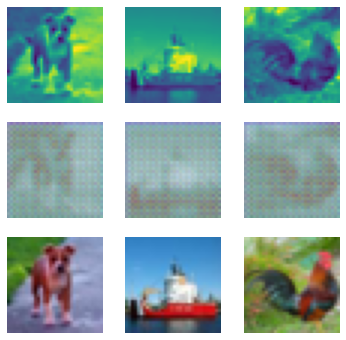

#################
For Epoch:1
Training Discriminator
Training Generator
Discriminator Loss: 2.4326070743493546
Generator loss: 0.6845390252577953


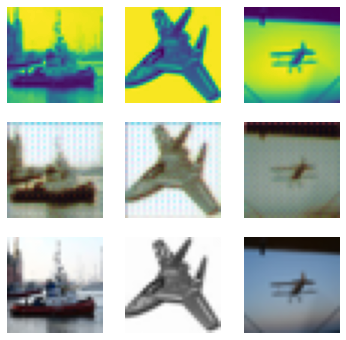

#################
For Epoch:2
Training Discriminator
Training Generator
Discriminator Loss: 1.5211360746469254
Generator loss: 0.6772604425748189


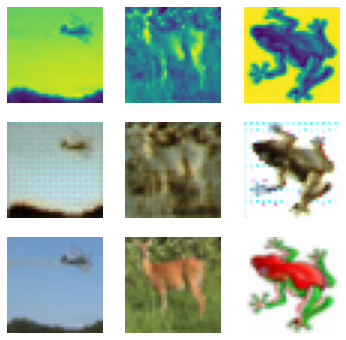

#################
For Epoch:3
Training Discriminator
Training Generator
Discriminator Loss: 1.4111834346483916
Generator loss: 0.6745263570394271


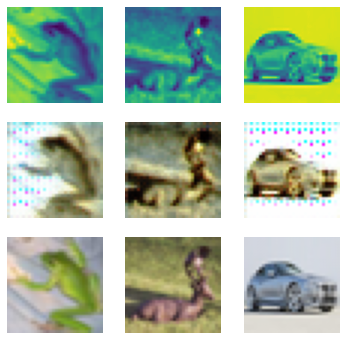

#################
For Epoch:4
Training Discriminator
Training Generator
Discriminator Loss: 1.4239932882480133
Generator loss: 0.6730107105695284


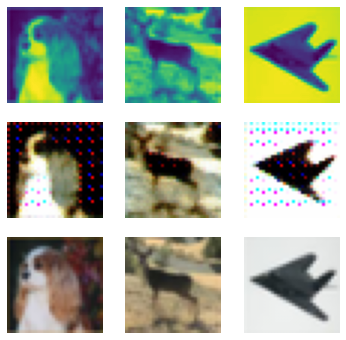

#################
For Epoch:5
Training Discriminator
Training Generator
Discriminator Loss: 1.412548061593985
Generator loss: 0.6724786804272578


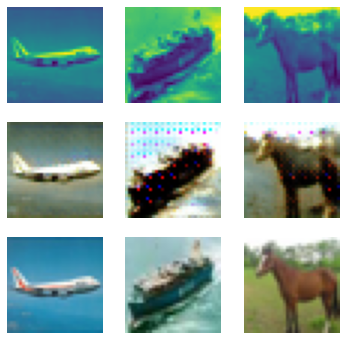

#################
For Epoch:6
Training Discriminator
Training Generator
Discriminator Loss: 1.3873210375889753
Generator loss: 0.6714443741700589


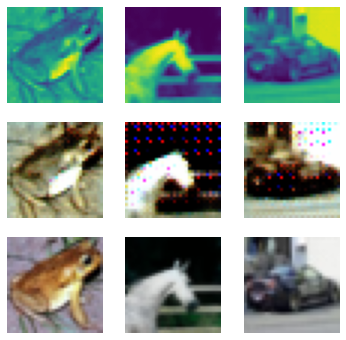

#################
For Epoch:7
Training Discriminator
Training Generator
Discriminator Loss: 1.3339488617884807
Generator loss: 0.670682215079283


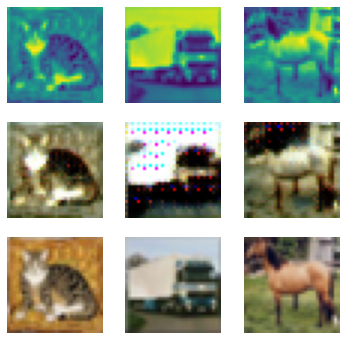

#################
For Epoch:8
Training Discriminator
Training Generator
Discriminator Loss: 1.34390123685201
Generator loss: 0.67000616085835


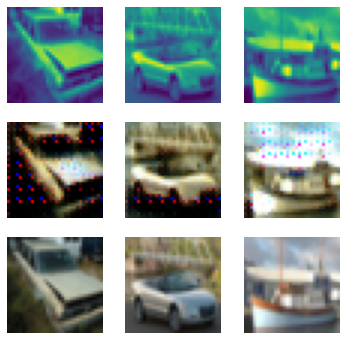

#################
For Epoch:9
Training Discriminator
Training Generator
Discriminator Loss: 1.3556560971798042
Generator loss: 0.6716061118321541


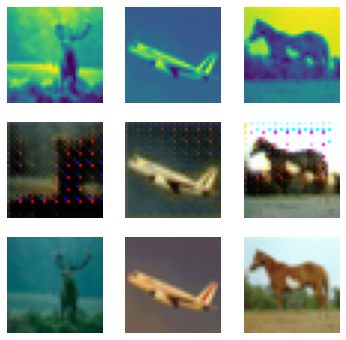

#################
For Epoch:10
Training Discriminator
Training Generator
Discriminator Loss: 1.3694260416122583
Generator loss: 0.670178816257379


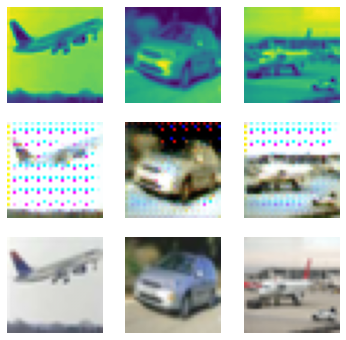

#################
For Epoch:11
Training Discriminator
Training Generator
Discriminator Loss: 1.322674951950709
Generator loss: 0.6697131927196797


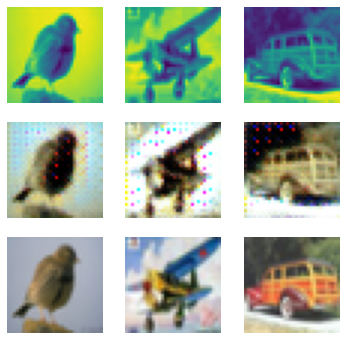

#################
For Epoch:12
Training Discriminator
Training Generator
Discriminator Loss: 1.3995211015909146
Generator loss: 0.6685960054397583


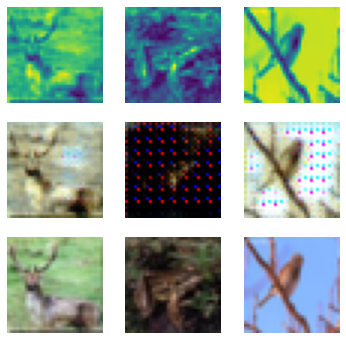

#################
For Epoch:13
Training Discriminator
Training Generator
Discriminator Loss: 1.376085005968045
Generator loss: 0.6684108281746889


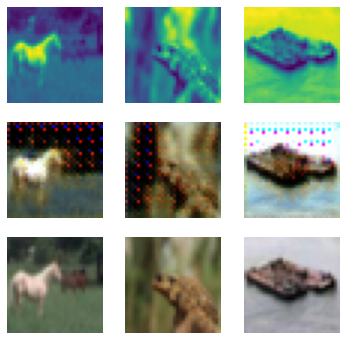

#################
For Epoch:14
Training Discriminator
Training Generator
Discriminator Loss: 1.3343822003939212
Generator loss: 0.6699523644569593


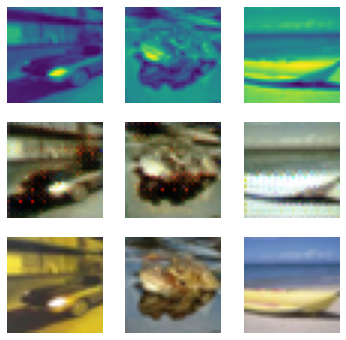

#################
For Epoch:15
Training Discriminator
Training Generator
Discriminator Loss: 1.375189426006415
Generator loss: 0.6681874605325552


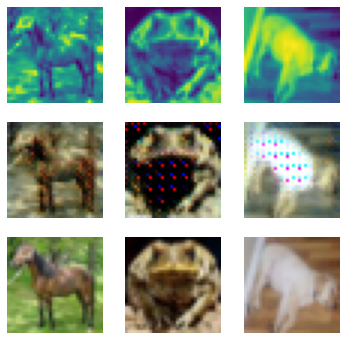

#################
For Epoch:16
Training Discriminator
Training Generator
Discriminator Loss: 1.3305301748789273
Generator loss: 0.6674203417240046


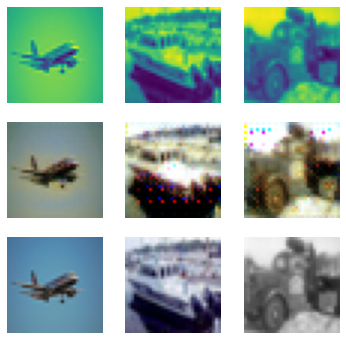

#################
For Epoch:17
Training Discriminator
Training Generator
Discriminator Loss: 1.3791387170553207
Generator loss: 0.6671961796589386


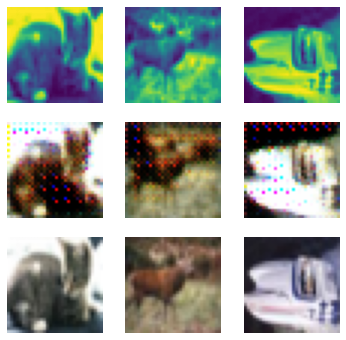

#################
For Epoch:18
Training Discriminator
Training Generator
Discriminator Loss: 1.4233687753860766
Generator loss: 0.6674184493529491


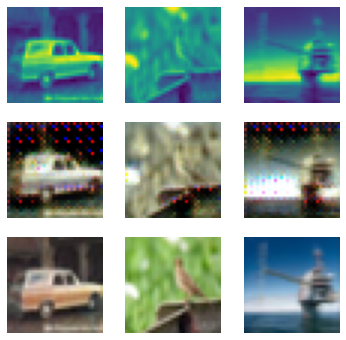

#################
For Epoch:19
Training Discriminator
Training Generator
Discriminator Loss: 1.338590836372131
Generator loss: 0.6671486976819161


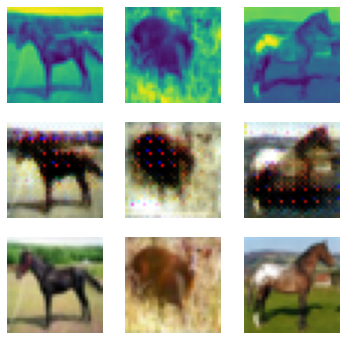

In [16]:
genLoss, discLoss = train(X_train, Y_train, epochs)

In each picture, there are 3 random images being picked to plot in each column. While for a fixed column (image), three rows from the top to the botton are the `single-color images (1-channel), generated images, and the real_images`. We can see than with epochs growing, the generated images are looked increasingly real and clear and much more like the real images.

## Evaluate the model
We plot the history of the model training loss and further see the model performance on the see data to evaluate.

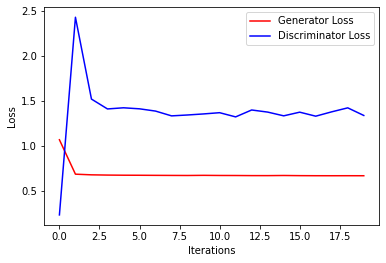

In [17]:
#Plot the model loss history to evaluate
plt.plot(genLoss, c='r', label="Generator Loss")
plt.plot(discLoss, c='b', label="Discriminator Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

We can see both generator loss and the discriminator loss decrease with time, which means that the model performs well on the training set. Furthermore, we can evaluate the model on the test set by picking some random test data and plot the predictions from the model.

In [0]:
# generate_and_save_images(generator, 0, X_test, Y_test, False)